# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |



## Introducción
En este práctico se propone explorar un dataset que contiene información de varias agencias de correo de Brasil, con el objetivo de extraer toda la información relevante sobre estos datos y presentarla de manera organizada y sencilla.
En estos datos vamos a encontrar información geográfica de los compradores y vendedores, el tipo de servicio por el que viajan los paquetes, el estado del paquete, algunas fechas relevantes y la cantidad de días hábiles que tardó el envío en llegar a su destino (target).

## Dataset

## Definiciones

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})
#plt.figure(figsize=(10,6))

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

In [2]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [3]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


#### Feriados

In [4]:
df_h = pd.read_csv(holidays, usecols=cols_holidays)
df_h.shape

(26, 2)

In [5]:
df_h.sample(5)

,holiday,description
13,2019-11-19,Dia da Consciência Negra
0,2019-02-12,Carnaval
8,2019-11-14,Proclamação da República
22,2019-11-01,Finados
11,2019-10-11,Dia das Crianças


# 1. Información general

**1.1 Cantidad y proporción de envíos, servicios, tipos de envíos y rutas (consideramos como ruta la tripla zipcode, zipcode, servicio).**


In [6]:
services = pd.unique(df['service']).tolist()
print(f"Cantidad de servicios: {len(services)}")

Cantidad de servicios: 12


In [7]:
print(f"Cantidad de envíos: {len(df)}")

Cantidad de envíos: 1000000


Cantidad de envíos por servicio:

In [8]:
df['service'].value_counts()

1     501509
0     321839
4      58517
2      49185
3      22057
5      20116
6      17602
8       5288
9       3224
7        528
10       134
11         1
Name: service, dtype: int64

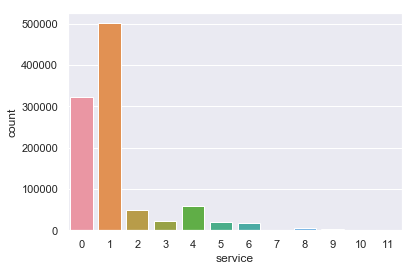

In [9]:
sb.countplot(data=df, x='service')

Cantidad de envíos por tipo de envío:

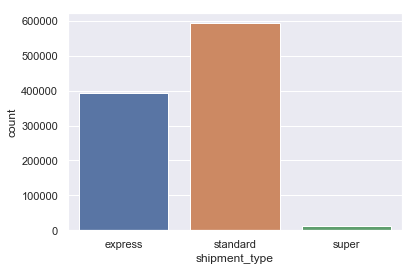

In [10]:
sb.countplot(data=df, x='shipment_type')

In [11]:
df['shipment_type'].value_counts()


standard    593467
express     394600
super        11933
Name: shipment_type, dtype: int64

In [12]:
routes = pd.DataFrame(df, columns=['sender_zipcode', 'receiver_zipcode', 'service']).copy()
routes = routes.sort_values(by=['service']).copy()
print(f"Cantidad de rutas: {len(routes.drop_duplicates())}")

Cantidad de rutas: 945777


In [13]:
routes.head()


,sender_zipcode,receiver_zipcode,service
0,3005,5409,0
740868,9580,41720,0
320312,14070,59700,0
740871,3572,4616,0
320310,4904,17022,0


In [14]:
routes_by_services = [route for _ , route in routes.groupby(routes['service'])]

**Cantidad de rutas utilizadas por cada servicio:**

In [15]:
# Creating an empty Dataframe with column names only
df_routes = pd.DataFrame(columns=['service', 'amount_routes'], dtype=int)

for service_id, service in enumerate(routes_by_services):
    df_routes = df_routes.append({'service': service_id, 'amount_routes': len(service)}, ignore_index=True)
df_routes

,service,amount_routes
0,0,321839
1,1,501509
2,2,49185
3,3,22057
4,4,58517
5,5,20116
6,6,17602
7,7,528
8,8,5288
9,9,3224


**1.2 Puntos máximos y mínimos de cada feature.**


In [16]:
df['target'].describe()

count    1000000.000000
mean           6.021577
std            5.157973
min            0.000000
25%            2.000000
50%            4.000000
75%            9.000000
max          118.000000
Name: target, dtype: float64

In [17]:
print(f"Primera fecha de creación envío: {df['date_created'].min()}")
print(f"Ultima fecha de creación envío: {df['date_created'].max()}")

print(f"Primera fecha de envío: {df['date_sent'].min()}")
print(f"Ultima fecha de envío: {df['date_sent'].max()}")
      
print(f"Primera fecha de entrega del envío: {df['date_visit'].min()}")
print(f"Ultima fecha de entregaa del envío: {df['date_visit'].max()}")
      

Primera fecha de creación envío: 2018-09-26 00:00:00
Ultima fecha de creación envío: 2019-06-28 00:00:00
Primera fecha de envío: 2018-10-01 16:55:00
Ultima fecha de envío: 2019-03-29 07:06:00
Primera fecha de entrega del envío: 2019-02-28 00:03:00
Ultima fecha de entregaa del envío: 2019-03-29 23:31:00


In [18]:
print(f"Cantidad mínima de items en el envío : {df['quantity'].min()}")
print(f"Cantidad máxima de items en el envío : {df['quantity'].max()}")


Cantidad mínima de items en el envío : 1
Cantidad máxima de items en el envío : 5


**1.3 Calcular estadísticos como la media, mediana, desviación estándar y percentiles del
target.**

In [19]:
print(f"Valor minimo: {df['target'].min()}")
print(f"Valor maximo: {df['target'].max()}")
print(f"Media: {df['target'].mean()}")
print(f"Dev std: {df['target'].std()}")
print(f"Mediana: {df['target'].median()}")
      

Valor minimo: 0
Valor maximo: 118
Media: 6.021577
Dev std: 5.157973055157452
Mediana: 4.0


**1.4 Graficar la distribución del target ¿Responde a alguna distribución conocida?**


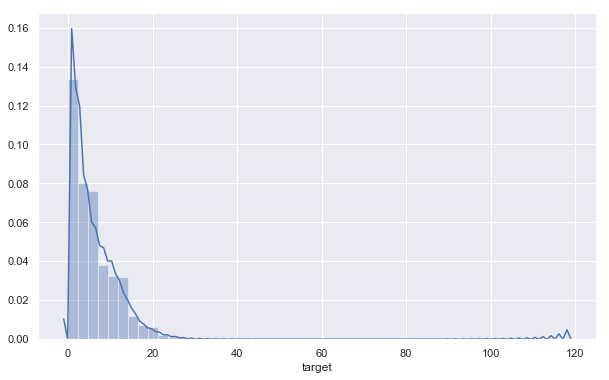

In [20]:
plt.figure(figsize=(10,6))
sb.distplot(df['target'])

La distribución tiene apariencia de distribuír como una exponencial.

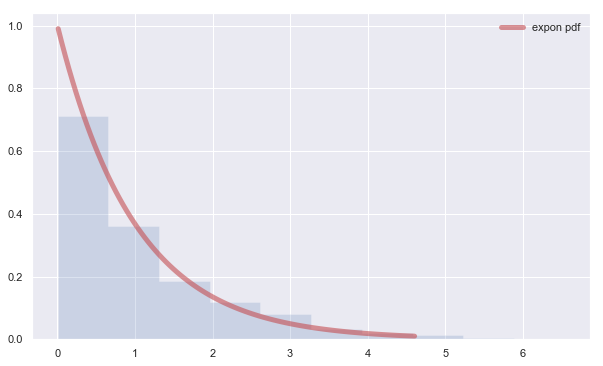

In [230]:
from scipy.stats import expon

x = np.linspace(expon.ppf(0.01), expon.ppf(0.99), 100)
r = expon.rvs(size=1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, expon.pdf(x), 'r-', lw=5, alpha=0.6, label='expon pdf')
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

Lo comprobamos aplicancando un test de hipotesis KS.

In [ ]:
from scipy.stats import expon, kstest
kstest(df['target'], expon(scale=1.0 / df['target'].mean()).cdf)

Sin embargo el estadistico KS(Kolmogorov-Smirnov) da un p-valor demasiado bajo
Por lo tanto se rechaza la hipotesis de que el atributo target distribuya como exponencial.

**1.5 Graficar solo la parte más informativa de la distribución del target , teniendo cuidado
con elegir correctamente los parámetros de los gráficos, como la cantidad de bins en
un histograma.**


Ploteamos hasta donde se concentran el 99% de los datos dejando fuera los outliers

In [ ]:
plt.figure(figsize=(10,6))
df1 = df[df['target'] <= df['target'].quantile(0.99)]
sb.distplot(df1['target'], bins=100)

**1.6 Identificar y graficar outliers. ¿Son significativos?**


In [ ]:
#plt.figure(figsize=(15,10))
sb.set(rc={'figure.figsize':(10.5,8.5)})
sb.boxplot(x=df['service'], y=df['target'], data=df, palette="Set1")

Análisis para servicio 0:

In [ ]:
df[df['service'] == 0]['target'].quantile(0.75)

In [ ]:
df[df['service'] == 0]['target'].quantile(0.99)

In [ ]:
service_0 = len(df[df['service'] == 0])
service_0_9 = len(df[(df['service'] == 0 ) & (df['target'] < 9)])
service_0 - service_0_9

El 75% de los envíos tardó a lo sumo 3 dias en ser entregado.
El 99% de los envíos tardó a lo sumo 9 dias en ser entregado.
Esto indica que hay un 1% de envíos que demoraron entre 10 y 61 días. Estos son outliers para el servicio 0
En total son 4569 paquetes que demoraron entre 10 y 61 días



Analisís para el resto de los servicios:

In [ ]:
for i in range(12):
    per_75 = df[df['service'] == i]['target'].quantile(0.75)
    print(f"percentil 75 para servicio {i} = {per_75}")

In [ ]:
for i in range(12):
    per_99 = df[df['service'] == i]['target'].quantile(0.99)
    print(f"percentil 99 para servicio {i} = {per_99}")

Claramente se observa que cualquier entrega que haya tomado más de 25 días en ser entregado es un ouliers
También se observa que el servicio 1 en general demora muchos mas dias en entregar sus paquetes.
Aunque tambien hay que destacar que este servicio es el que mas paquetes envía.
Es de destacar que el servicio 7 es uno de los que mas demora aun enviando solo 505 paquetes.


Sobre el servicio 7 se puede analizar un poco más en detalle que en el tiempo observado solo envió paquetes en dos meses y medio, (entre Enero y Febrero). Lo que puede significar que no fueron observadas muchas muestras para otros meses para este servicio, o tal vez es un servicio con una vigencia temporal.

In [ ]:
df[df['service'] == 7 ]['date_sent'].min()

In [ ]:
df[df['service'] == 7 ]['date_sent'].max()

In [ ]:
df[df['service'] == 7 ]['target'].describe()

El total de outliers sobre el 99% de los envíos para todos los servicios es de 4063 paquetes.
No resultan ser significativos desde un punto de vista análitico, aunque es necesario analizar el impacto económico

In [ ]:
outliers = len(df[df['target'] > 25])
outliers

**1.7 ¿Los fines de semana son diferentes a los días de semana? ¿En qué sentido?**


In [ ]:
import datetime as dt

In [ ]:
date_by_days = df.copy()
date_by_days['date_created'] = pd.to_datetime(date_by_days['date_created'])
date_by_days['dn_date_created'] = date_by_days['date_created'].apply(lambda x: x.day_name())
date_by_days['date_sent'] = pd.to_datetime(date_by_days['date_sent'])
date_by_days['dn_date_sent'] = date_by_days['date_sent'].apply(lambda x: x.day_name())
date_by_days['date_visit'] = pd.to_datetime(date_by_days['date_visit'])
date_by_days['dn_date_visit'] = date_by_days['date_visit'].apply(lambda x: x.day_name())

In [ ]:
date_by_days['dn_date_created'].value_counts()

In [ ]:
sb.set(rc={'figure.figsize':(10,5)})
sb.countplot(date_by_days['dn_date_created'])

Como podemos observar los servicios de correo crean sus envios mayormente en días de la semana, mientras que los fines de semana se crean menos envíos.

In [ ]:
date_by_days['dn_date_sent'].value_counts()

In [ ]:
sb.countplot(date_by_days['dn_date_sent'])

Tambien se observa que los servicios de correo envían sus paquetes mayormente en días de la semana, mientras que los fines de semana se envían menos paquetes.

In [ ]:
date_by_days['dn_date_visit'].value_counts()

In [ ]:
sb.countplot(date_by_days['dn_date_visit'])

Finalmente los servicios de correo entregan sus paquetes mayormente en los días Jueves, mientras que los fines de semana se realizan menos entregas.

**1.8 ¿Existe algún periodo de tiempo diferente a los demás? Comparar gráficamente las
distribuciones de los targets (Puede ayudar utilizar información externa).**


In [ ]:
data_sorted_by_date = df.sort_values(by=['date_sent']).copy()
# delete hours- min- sec
data_sorted_by_date['date_sent'] = pd.to_datetime(data_sorted_by_date['date_sent']).dt.date
data_sorted_by_date['date_created'] = pd.to_datetime(data_sorted_by_date['date_created']).dt.date
data_sorted_by_date['date_visit'] = pd.to_datetime(data_sorted_by_date['date_visit']).dt.date



In [ ]:
sb.lineplot(x='date_sent', y='target', data=data_sorted_by_date)

Se observa que los primeros dias muestreados el servicio 1 realizó envíos que demoraron varios meses


In [ ]:
data_sorted_by_date.head()

Del ejercicio 1.5, sabemos que el 99% de las entregas tomo como a lo sumo 22 dias. Con esa información
y observando el primer gráfico de este punto, sabemos que esas entregas se concretaron a partir de febrero de 2019
Es decir que entre Febrero y Abril de 2019 se enviaron y entregaron el 99% de los paquetes.


**1.9 Observando la distribución del target semana a semana. Explicar que sucede y cuál
puede ser la razón. Graficar las distribuciones en conjunto o la diferencia entre ellas.**


In [ ]:
df1 = data_sorted_by_date.sort_values(by=['date_sent']).copy()
df1['date_sent'] = pd.to_datetime(df1['date_sent']) - pd.to_timedelta(7, unit='d')
df2 = df1.set_index('date_sent').resample('W')["target"].sum()
df3 = pd.DataFrame({'target_by_week' : df1.set_index('date_sent').resample('W')["target"].sum()}).reset_index()
df3

In [ ]:
plt.figure(figsize=(10,6))
sb.distplot(df3['target_by_week'], bins=10)

**1.10 ¿Existen rutas más representadas que otras?**


Asi es:

In [ ]:
df1 = routes[routes.duplicated()]
df2 = df1.groupby(df1.columns.tolist()).size().reset_index().rename(columns={0:'count'})
df2 = df2.sort_values(by=['count'], ascending=[False])
df2.head()

**1.11 La cantidad de items por paquete, ¿tiene relación con la velocidad del envío?**


Se realiza análisis de correlación entre las variab

In [ ]:
df[['quantity', 'target']].corr(method='spearman')

In [ ]:
df[['quantity', 'target']].corr(method='pearson')

In [ ]:
g = sb.jointplot(x=df['quantity'], y=df['target'],
                 data=df, kind="reg",
                 line_kws={'color':'green'},
                 scatter_kws={'alpha': 0.33})
g.fig.set_size_inches(8, 8)
g.fig.suptitle("quantity vs target",
               fontsize=16, weight="bold", y=1.05)

las variables no estan relacionadas

**1.12 ¿Existen variables correlacionadas?**


Se realiza análisis para variables cuantativas.

In [ ]:
df1 = df[['quantity', 'target', 'service', 'status' ]]
g = sb.pairplot(df1)

In [ ]:
df[['service', 'target', 'quantity']].corr(method='spearman')

In [ ]:
df[['service', 'target', 'quantity']].corr(method='pearson')

No se perciben correlaciones entre las variables numericas

**1.13 Graficar la distribución del target agrupando por tipo de envío.**


Recordamos la distribución de target para todos los datos de la muestra

In [ ]:
sb.distplot(df['target'], kde_kws={"lw": 3})
plt.title('Target: Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.')


Distribución de target para los tipos standar y express 

In [ ]:
target_0 = df[df['shipment_type'] == 'standard']['target']
target_1 = df[df['shipment_type'] == 'express']['target']

sb.distplot(target_0, hist=True, rug=True, rug_kws={"color": "g"},
            kde_kws={ "lw": 3, "label": "standar", "color": "g" })
sb.distplot(target_1, hist=True, rug=True, kde_kws={ "lw": 3, "label": "express"})


La variable target para el tipo de envío super tiene muchos mas valores de target concentrados entre cero y dos días lo que indica que este tipo de servicio es más premium.

In [ ]:
target_2 = df[df['shipment_type'] == 'super']['target']
sb.distplot(target_2, hist=True, rug=True,  rug_kws={"color": "r"}, 
            kde_kws={ "lw": 3, "label": "super",  "color": "r"})


**1.14 Determinar cuales son los servicios y los estados más representados**


In [ ]:
df['service'].value_counts()

In [ ]:
df['status'].value_counts()

# 2. Servicios

**2.1 Graficar solo la parte más informativa de la distribución del target para los 4
servicios más representados, con los cuidados correspondientes.**


In [ ]:
df_1=df.copy()

Contamos las representaciones de los servicios para luego tomar de ellos los servicios más representados

In [ ]:
df_1['service'].value_counts()

Podemos observar con esto que los cuatro servicios más representados son: (1, 0, 4, 2), de los cuales obtendremos la parte más informativa.


In [ ]:
df_serv= df_1[df_1['service'].isin([1, 0, 4, 2])]

In [ ]:
df_serv.head()

Realizamos un gráfico distplot que grafica la distribución del target para los 4 servicios sin diferenciarlos.

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv['target'], bins= 100)

Busco representar sólo la parte más informativa de la distribución target, para ello observo donde se encuentran la mayoría de los datos significativos

In [ ]:
df_serv['target'].quantile(0.99)

El 99% se encuentra por debajo del 23.0 por lo cual es en este intervalo que se encuentran en su mayoría los datos significativos

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv[df_serv['target']<24]['target'], bins=23)
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv[(df_serv['target']<24)&(df_serv['service']==1)]['target'], bins=23)
plt.title('servicio1')



Podemos ver en esta distribución del target para el servicio 1 que la mayoría de los paquetes se entregan entre 5 y 10 días

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv[(df_serv['target']<24)&(df_serv['service']==0)]['target'], bins=23)
plt.title('servicio0')

Podemos ver en esta distribución del target para el servicio 0 que la mayoría de los paquetes se entregan entre 1 y 4 días

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv[(df_serv['target']<24)&(df_serv['service']==4)]['target'], bins=23)
plt.title('servicio4')

Podemos ver en esta distribución del target para el servicio 4 que la mayoría de los paquetes se entregan entre 1 y 4 días

In [ ]:
plt.figure(figsize=(15,6))
sb.distplot(df_serv[(df_serv['target']<24)&(df_serv['service']==2)]['target'], bins=23)
plt.title('servicio2')

Podemos ver en esta distribución del target para el servicio 2 que la mayoría de los paquetes se entregan entre 1 y 4 días

**2.2 ¿Existen servicios más rápidos que otros?**

En caso de existir servicios mas rápidos que otros sería interesante ver aquellos con menor target (debido al inciso anterior tomamos aquellos más significativos correspondientes a ['target']<24), es decir, 
aquellos servicios en los que el numero de cantidad de días hábiles que demora la entrega sea menor. 
Para ello agrupamos por servicios y comparamos los targets promedios correspondientes a cada tipo de servicio.


In [ ]:
df_fast=df_1[df_1['target']<24].groupby(['service'],as_index=False).agg({'target':'mean'})

In [ ]:
df_fast

In [ ]:
sb.barplot(data=df_fast, x='service', y='target')

En promedio podemos decir que si existen servicios que demoran más que otros en este caso se trata de las barras más altas. Sin embargo, los servicios más pedidos son 1 (que corresponde a la barra más alta i.e. mayor demora), 0, 4, 2. Se observa además, que el servicio 7 posee una media demora muy alta (es el segundo en cuanto a demora) a pesar de no corresponder a los servicios que envíen más paquetes como es el caso del servicio 1; por ello restaría analizar a que podría deberse esto: como por ejemplo Región, calidad, Precio, en que consiste el tipo de servicio 7, etc. Además en el inciso 1.6 se puede observar que en el tiempo observado el servicio 7 solo envió paquetes en dos meses y medio, (entre Enero y Febrero).
Por otra pate los servicios 5 y 8 son los que poseen menor demora.

**2.3 ¿Existen servicios similares entre sí? ¿Alguna idea de porque?**

Con el objetivo de analizar las similitudes de los servicios agrupo por vez los servicios con alguna 
característica de los mismos y tratamos de ver cuales servicios comparten características

In [ ]:
df_ss_ser=df.groupby(['sender_state','service'],as_index=False).agg({}) #agrupo

df_sz_ser=df.groupby(['sender_zipcode','service'],as_index=False).agg({})

df_rs_ser=df.groupby(['receiver_state','service'],as_index=False).agg({})

df_rz_ser=df.groupby(['receiver_zipcode','service'],as_index=False).agg({})

df_st_ser=df.groupby(['shipment_type','service'],as_index=False).agg({})

df_q_ser=df.groupby(['quantity','service'],as_index=False).agg({})

df_s_ser=df.groupby(['status','service'],as_index=False).agg({})

df_dc_ser=df.groupby(['date_created','service'],as_index=False).agg({})

df_ds_ser=df.groupby(['date_sent','service'],as_index=False).agg({})

df_dv_ser=df.groupby(['date_visit','service'],as_index=False).agg({})

df_t_ser=df.groupby(['target','service'],as_index=False).agg({})



Veamos si existe alguna relación entre service y las otras columnas

In [ ]:
plt.figure(figsize=(10,5))

sb.scatterplot(data=df_ss_ser, x='sender_state', y='service')

Existen servicios similares entre sí, en este caso 0-1 y por otra parte 2-10 coinciden en sender_state

In [ ]:
plt.figure(figsize=(10,5))

sb.scatterplot(data=df_st_ser, x='shipment_type', y='service')

Viendo el shipment_type los servicios que  son los siguientes: 
0, 3 y 6 (coinciden los 3), el 1, 2, 4, 7, 9, 10 (coinciden en express y en standard), el 8 y el 11(express), y el 5(express y super)


In [ ]:
plt.figure(figsize=(10,5))

sb.scatterplot(data=df_rs_ser, x='receiver_state', y='service')

Viendo el receiver_state coinciden los servicios: 0, 1, 2, 6 (coinciden todos). Además,  5, 8 y 11 coinciden en sp. Todos los demás son distintos entre sí

In [ ]:
plt.figure(figsize=(10,5))

sb.scatterplot(data=df_s_ser, x='status', y='service')

Viendo status los servicios 0, 1, 2, 4, 5, 6, 7, 9 (coinciden en done, failed y sent), el 3 tiene todos los status y 8 (done y failed)

**2.4 (Extra) ¿Podrías identificar cuántos correos aparecen en los datos?**


# 3. Estados

**3.1 Graficar solo la parte más informativa de la distribución del target para los 4 estados
más representados, con los cuidados correspondientes.**


Buscamos cuales son los 4 estados mas representados utilizando 'receiver_state'

In [ ]:
plt.figure(figsize=(12,6))
sb.countplot(data=df, x='receiver_state')

Observamos que los 4 estados mas representados son "SP", "MG", "RS" y "RJ". Filtramos nuestro dataset para esos 4 estados.

In [ ]:
filtered_states = df[df['receiver_state'].isin(["SP", "MG", "RS", "RJ"])]

Graficamos la distribucion de 'target' en un boxplot, para identificar los valores que pueden considerarse outliers

In [ ]:
plt.figure(figsize=(12,6))
sb.boxplot(filtered_states['target'])

Graficamos la distribucion de los targets eliminando los outliers superiores a 15

In [ ]:
targets = filtered_states[filtered_states['target'] <= 15]['target']
plt.figure(figsize=(12,6))
sb.distplot(targets)

**3.2 ¿Cómo están distribuidos los vendedores geográficamente?**


Graficamos el conteo de 'sender_state'

In [ ]:
plt.figure(figsize=(12,6))
sb.countplot(data=df, x='sender_state')

Observamos una muy alta concentracion de vendedores en el estado 'SP'. Con una participacion casi despreciable en los demas estados, destacandose entre estos 'PR', 'RJ', 'SC', 'MG' y 'RS'.

**3.3 ¿Cómo es la participación de los servicios dentro y fuera de San Pablo?**


Graficamos el conteo de servicios en 'SP'

In [ ]:
sp=df[df['sender_state'] == 'SP']
plt.figure(figsize=(12,6))
sb.countplot(data=sp, x='service')

Graficamos ahora los servicios fuera de 'SP'

In [ ]:
no_sp=df[df['sender_state'] != 'SP']
plt.figure(figsize=(12,6))
sb.countplot(data=no_sp, x='service')

Observamos que fuera de San Pablo, la oferta de servicios es mucho mas limitada. Llegando unicamente los dos servicios mas grandes del pais.

**3.4 (Extra) ¿Podrías explicar porque estos estados están más representados que los
otros?.**


**3.5 Realizar un mapa de calor utilizando los zipcodes de los vendedores y los
compradores.**


In [227]:
def plot_heat_map(df, state, attribute):
    for i, value in enumerate(df):
        plt.figure(figsize=(8,4))
        title = routes_by_state[i][state].iloc[0]
        plt.title(f'{title}')
        sb.heatmap(routes_by_state[i][[attribute]], yticklabels=False)
        plt.show()

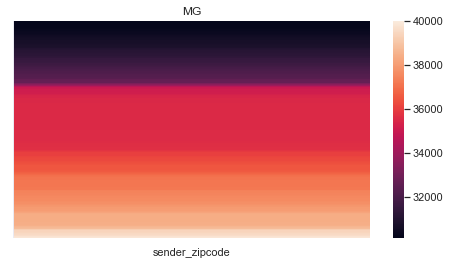

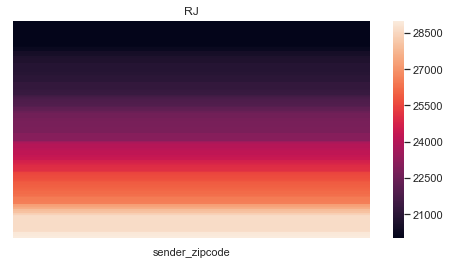

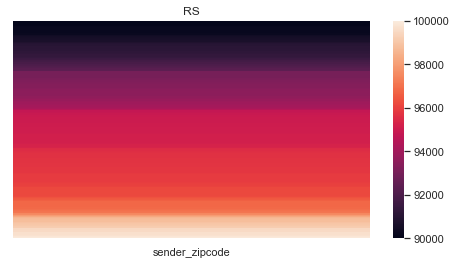

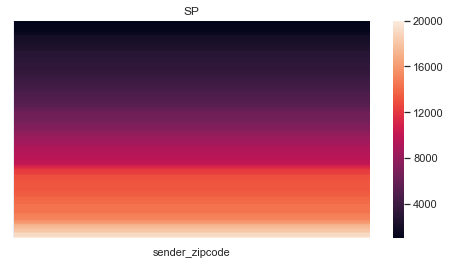

In [228]:
zipcodes = df[df['sender_state'].isin(["SP", "MG", "RS", "RJ"])]
zipcodes = zipcodes[['sender_state', 'sender_zipcode', 'receiver_zipcode']]
zipcodes = zipcodes.round(5)

zipcodes = zipcodes.sort_values(by=['sender_zipcode'])
routes_by_state = [state for _ , state in zipcodes.groupby(zipcodes['sender_state'])]
attribute = 'sender_zipcode'
state = 'sender_state'
plot_heat_map(routes_by_state, state, attribute)

Los heat-map ploteados para el zip code de los vendedores de los cuatro estados que más vendieron, nos permiten discriminar los rangos de zip code para cada estado y el rango de regiones dentro de cada estado envió más correos. 
    
El estado **SP** contiene zip codes de correos enviados en el rango 4000-20000. Con predominio en el rango 4000-8000.

El estado **RJ** contiene zip-codes de correos enviados en el rango 21000-28500.

El estado **MG** contiene zip-codes de correos enviados en el rango 32000-40000. Con predominio en el rango 35000-40000.

El estado **RS** contiene zip-codes de correos enviados en el rango 90000-100000.

Se puede aplicar un análisis mas detallado por cada grupo para determinar la cantidad de correos enviados por cada estado, su distribución, etc.
  

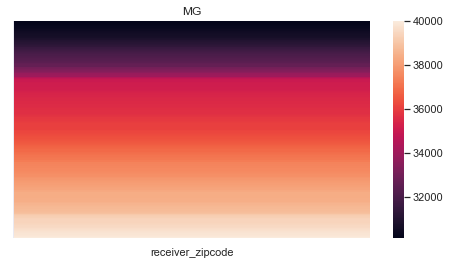

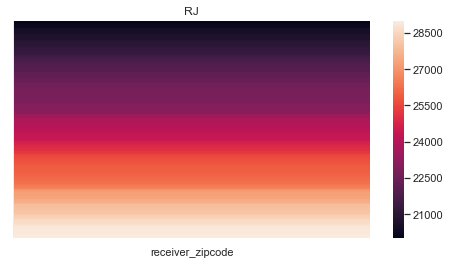

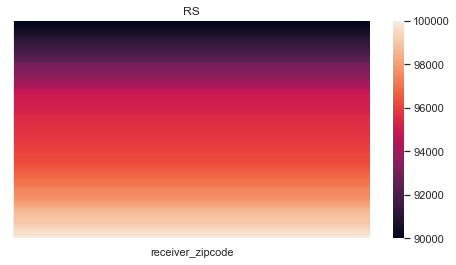

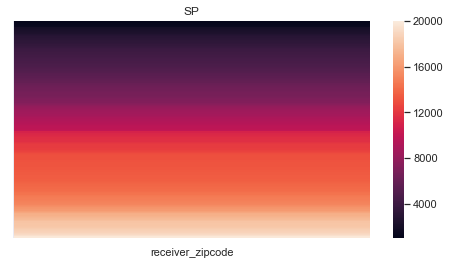

In [229]:
zipcodes = df[df['receiver_state'].isin(["SP", "MG", "RS", "RJ"])]
zipcodes = zipcodes[['receiver_state', 'sender_zipcode', 'receiver_zipcode']]
zipcodes = zipcodes.round(5)
zipcodes = zipcodes.sort_values(by=['receiver_zipcode'])
routes_by_state = [state for _ , state in zipcodes.groupby(zipcodes['receiver_state'])]
state = 'receiver_state'
attribute = 'receiver_zipcode'
plot_heat_map(routes_by_state, state, attribute)   

Los heat-map ploteados para el zip code de los compradores de los cuatro estados que más compraron, nos permiten discriminar los rangos de zip code para cada estado y el rango de regiones dentro de  cada estado que más compraron.

El estado **SP** contiene zip codes de correos recibidos en el rango 4000-20000. 

El estado **RJ** contiene zip-codes de correos recibidos en el rango 21000-28500.  

El estado **MG** contiene zip-codes de correos enviados en el rango 32000-40000. Los zonas que más correso recibieron se encuentran en el rango de zip-codes : 35000-40000. 

El estado **RS** contiene zip-codes de correos recibidos en el rango 90000-100000. Los zonas que más correso recibieron se encuentran en el rango de zip-codes : 96000-100000. 

Se puede aplicar un análisis mas detallado por cada grupo para determinar la cantidad de correos recibidos por cada estado, su distribución, etc.

**3.6 ¿Cual es la relación entre los zipcodes y los estados?**


In [ ]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=df,
                    x='sender_state',
                    y='sender_zipcode')

Se espera que utilicen las preguntas como guía de lo que se espera que vean en los datos,
todas las respuestas tienen que estar justificadas con datos o gráficos. Se evaluará la
legibilidad del notebook, el detalle a la hora de responder las preguntas y mostrar la
información solicitada, y además que los gráficos utilizados sean apropiados y correctos. La
información no contemplada en las preguntas que se logre encontrar y presentar
correctamente será valorada.

# 4. Conclusion